In [38]:
import xobjects as xo
import xpart as xp
import xcoll as xc
import numpy as np
import xtrack as xt
import pickle

import matplotlib.pyplot as plt
from scipy.stats import *
from madxtools.particles import *

import sys
import os
current_working_directory = os.getcwd()
module_directory = os.path.join(current_working_directory, '..')
absolute_module_directory = os.path.abspath(module_directory)
sys.path.append(absolute_module_directory)
from t07_functions import *

from scipy.stats import pearsonr, spearmanr, kendalltau

In [39]:
num_part = 5000
p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

# Make a transfer line
# ====================
k_qf_1 = 0.32730047
k_qd_2 = -0.36102915
k_qf_3 = 0.32789126
k_qd_4 = -0.1991137
l_quad = 2

elements = [
            xt.Quadrupole(k1=k_qf_1, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_2, length=l_quad),
            xt.Drift(length=29.),
            xt.Quadrupole(k1=k_qf_3, length=l_quad),
            xt.Drift(length=1.),
            xt.Quadrupole(k1=k_qd_4, length=l_quad),
            xt.Drift(length=89.),
            xt.Marker(),
           ]
element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                 "drift_4", "END"]
particle_ref = xp.Particles(energy0=p*1e9)
line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

# Add monitors
# ============
mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=15)
line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=20)
line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=65)
line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=70)

# Add octupoles

oct1 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
line.insert_element(element=oct1, name="oct1", at_s=40)
q1 = xt.Quadrupole(k1=0.5, length=0.402)
line.insert_element(element=q1, name="q1", at_s=50)

oct2 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
line.insert_element(element=oct2, name="oct2", at_s=58)
q2 = xt.Quadrupole(k1=0.5, length=0.402)
line.insert_element(element=q2, name="q2", at_s=60)


# Generate an initial distribution of particles
# =============================================
line.build_tracker(_context=xo.ContextCpu())

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.


In [40]:
line.vars['k_qf1'] = 0.5
line.element_refs['QF1'].k1 = line.vars['k_qf1']

In [41]:
line.vars['k_qf1'] = 0.6

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `default_only_xtrack`.


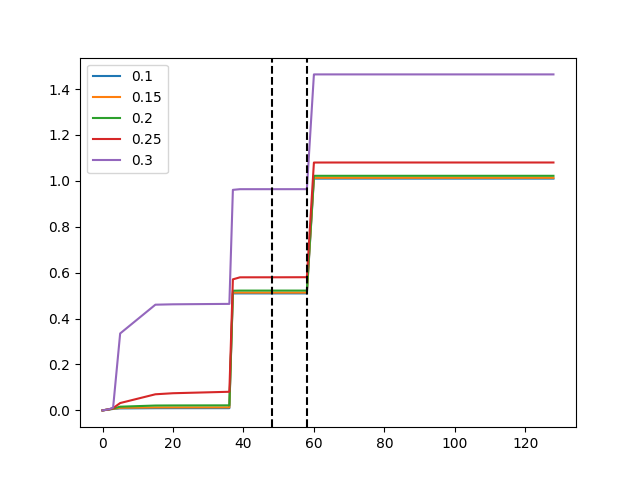

In [42]:
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
tw_df = tw.to_pandas()
tw_df[tw_df.name == 'oct2'].mux.iloc[0] - tw_df[tw_df.name == 'oct1'].mux.iloc[0]

fig, ax = plt.subplots()

for i in np.linspace(0.1, 0.3, 5):
    line.vars['k_qf1'] = i
    tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
    tw_df = tw.to_pandas()
    ax.plot(tw_df.s, tw_df.mux, label=f"{i}")
ax.legend()
ax.axvline(48, ls="--", c="k")
ax.axvline(58, ls="--", c="k")

In [43]:
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init, )

nemitt_x = exn
nemitt_y = eyn
x_norm, px_norm = xp.generate_2D_gaussian(num_part)
y_norm, py_norm = xp.generate_2D_gaussian(num_part)

part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()

Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


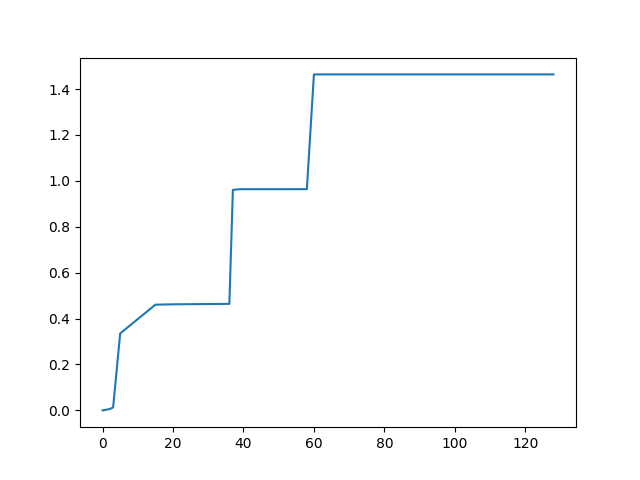

In [44]:
fig, ax = plt.subplots()
ax.plot(tw_df.s, tw_df.mux)

In [45]:
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

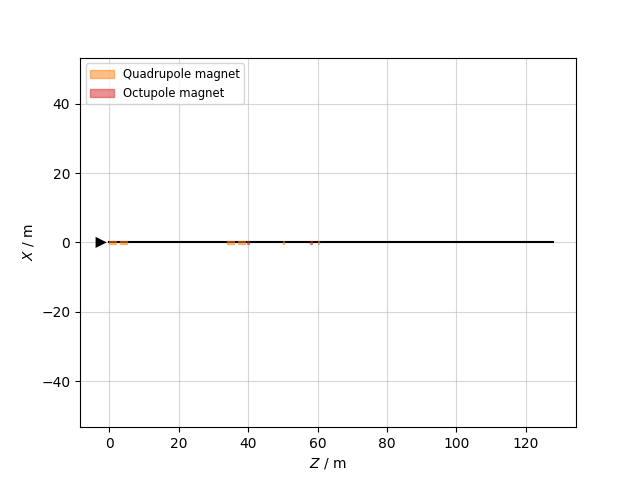

In [46]:
# Compute survey
sv = line.survey()
# Plot ring geometry using Xplt (credits P. Niedermayer)
import xplt
xplt.FloorPlot(sv, line)
plt.legend(fontsize='small', loc='upper left')

In [ ]:
line['q1'].k1 = 0.2
line['q2'].k1 = -0.2
# Loop through the tracking
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

Text(0.5, 1.0, 's = 70.0 m')

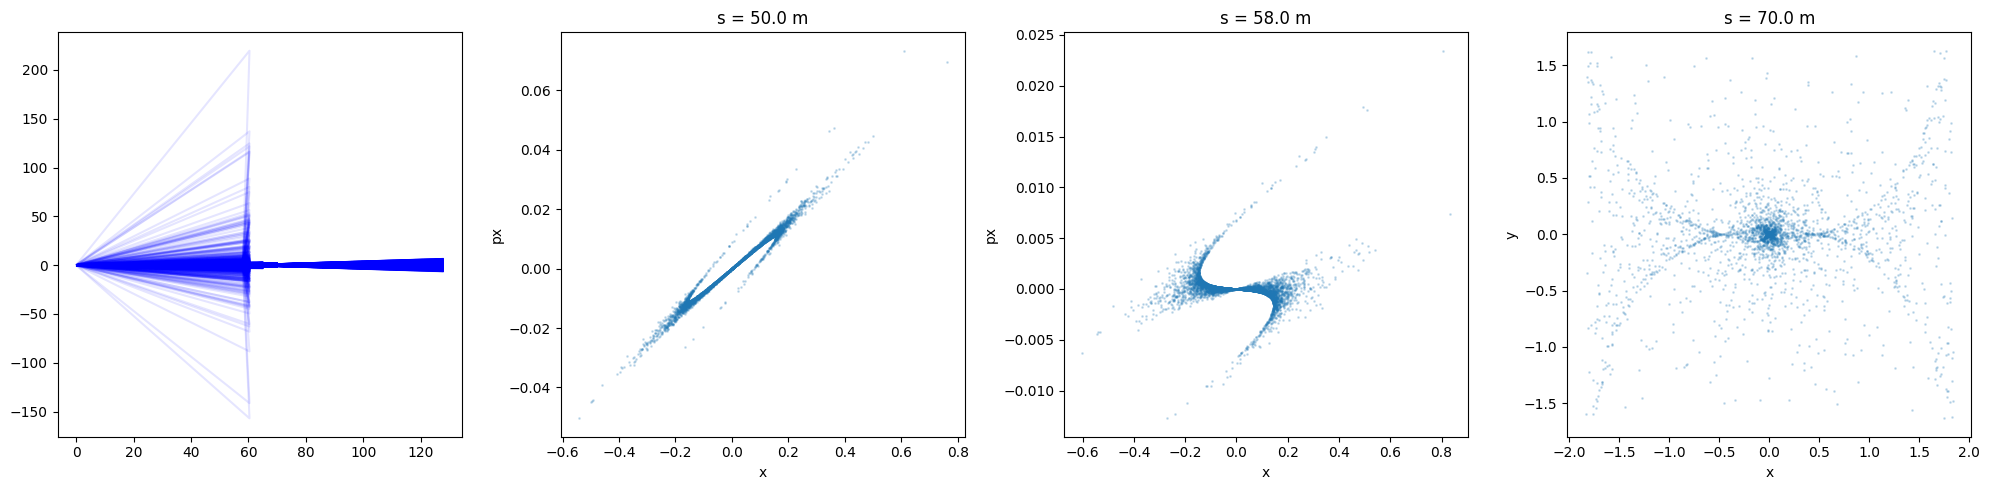

In [ ]:
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt

# Change and track
line['q1'].k1 = 0.2
line['q2'].k1 = -0.2
line['oct1'].knl = [0,0,0,400]
line['oct2'].knl = [0,0,0,400]
# Loop through the tracking
part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                            W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                            nemitt_x=nemitt_x,nemitt_y=nemitt_y)
part._init_random_number_generator()
line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

## Plot
fig, ax = plt.subplots(1,4, figsize=(20, 5), tight_layout=True)

# Create a collection of lines
lines = [list(zip(line.record_last_track.s[i], line.record_last_track.x[i])) for i in range(len(line.record_last_track.s))]
line_collection = LineCollection(lines, colors='blue', alpha=0.1)
ax[0].add_collection(line_collection)

# Set limits and labels
ax[0].autoscale()

# First octupoles
target_s = 49
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.px[:,s_index]
ax[1].scatter(x, px, alpha=0.2, s=1)
ax[1].set_xlabel("x")
ax[1].set_ylabel("px")
ax[1].set_title(f"s = {s_array[s_index]} m")

target_s = 59
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.px[:,s_index]
ax[2].scatter(x, px, alpha=0.2, s=1)
ax[2].set_xlabel("x")
ax[2].set_ylabel("px")
ax[2].set_title(f"s = {s_array[s_index]} m")


target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.y[:,s_index]
ax[3].scatter(x, px, alpha=0.2, s=1)
ax[3].set_xlabel("x")
ax[3].set_ylabel("y")
ax[3].set_title(f"s = {s_array[s_index]} m")


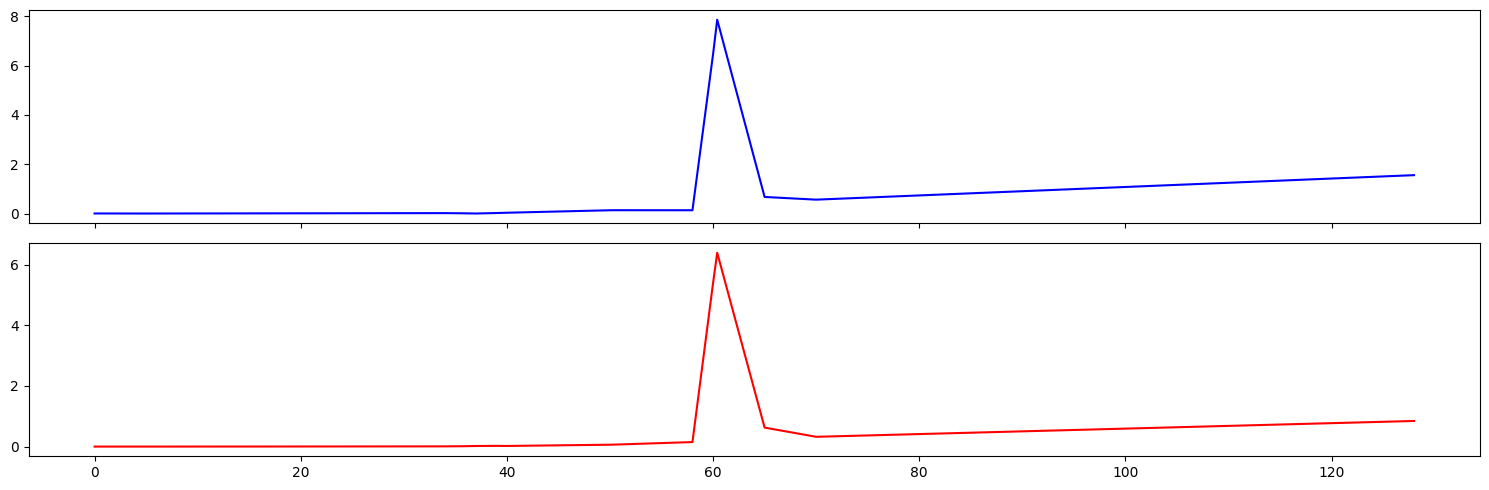

In [ ]:
fig,ax = plt.subplots(2,1, figsize=(15,5), tight_layout=True, sharex=True)

s_list = []
sigH_list = []
sigV_list = []

for i in range(len(tw.s)):
    s_list.append(tw.s[i])
    sigH_list.append(np.std(line.record_last_track.x[:,i]))
    sigV_list.append(np.std(line.record_last_track.y[:,i]))
ax[0].plot(s_list, sigH_list, c="b")
ax[1].plot(s_list, sigV_list, c="r")

import pandas as pd
d = {'s': s_list, 'sigH': sigH_list, 'sigV': sigV_list}
df = pd.DataFrame(data=d)

# Play with sliders

In [50]:
soln.x

array([ 0.20166339, -0.1117808 ,  0.09805626, -0.10752166,  0.09920568,
       -0.15209166, 45.63361247])

Output(layout=Layout(height='auto', width='70%'))

Output(layout=Layout(height='auto', width='70%'))

Output(layout=Layout(height='auto', width='70%'))

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


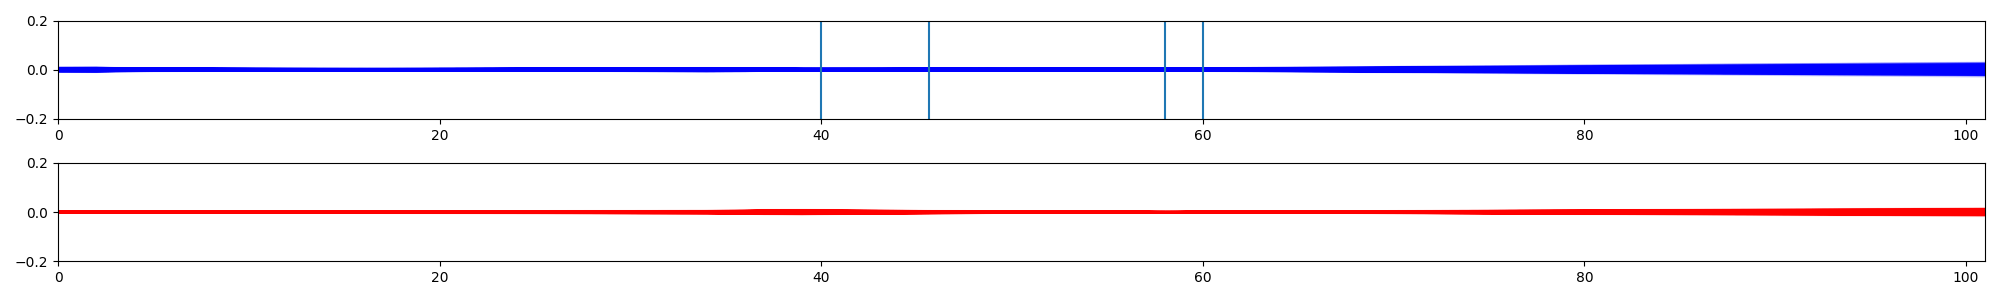

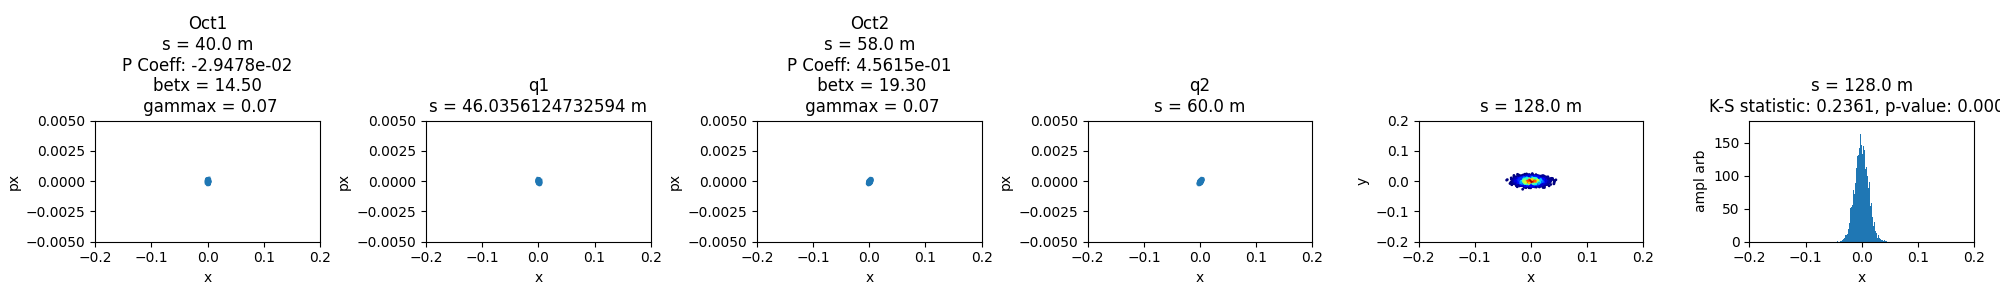

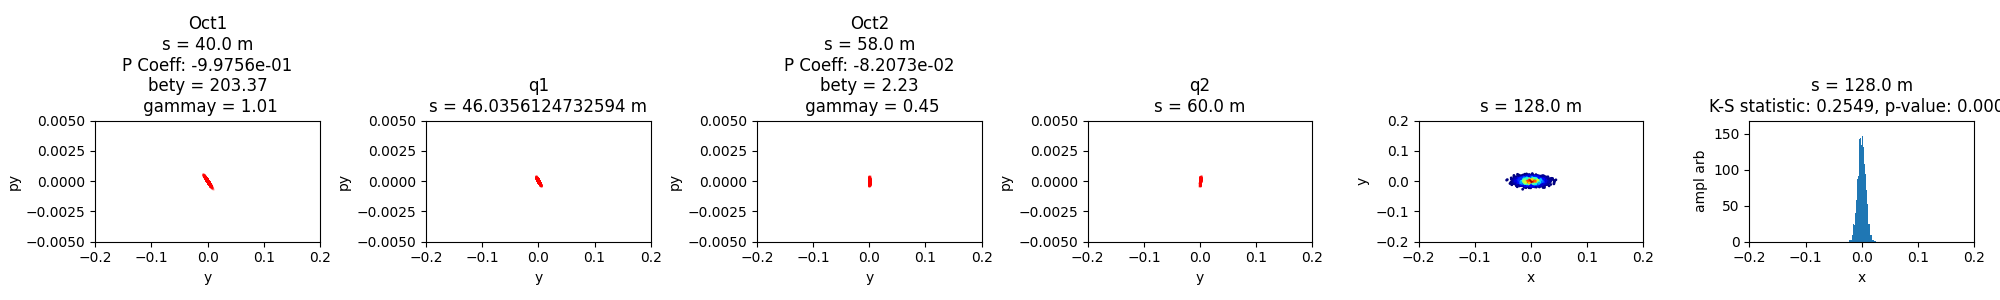

4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.


In [ ]:
from ipywidgets import interact, FloatSlider, Output, widgets, Layout, HBox
from matplotlib.collections import LineCollection
import matplotlib.pyplot as plt
%matplotlib widget

def update_and_plot(change):

    num_part = 5000
    p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

    # Make a transfer line
    # ====================
    k_qf_1 = 0.32730047
    k_qd_2 = -0.36102915
    k_qf_3 = 0.32789126
    k_qd_4 = -0.1991137
    l_quad = 2

    elements = [
                xt.Quadrupole(k1=k_qf_1, length=l_quad),
                xt.Drift(length=1.),
                xt.Quadrupole(k1=k_qd_2, length=l_quad),
                xt.Drift(length=29.),
                xt.Quadrupole(k1=k_qf_3, length=l_quad),
                xt.Drift(length=1.),
                xt.Quadrupole(k1=k_qd_4, length=l_quad),
                xt.Drift(length=89.),
                xt.Marker(),
            ]
    element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                    "drift_4", "END"]
    particle_ref = xp.Particles(energy0=p*1e9)
    line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

    # Add monitors
    # ============
    mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=15)
    line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=20)
    line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=65)
    line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=70)

    # Add octupoles
    oct1 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
    line.insert_element(element=oct1, name="oct1", at_s=40)
    q1 = xt.Quadrupole(k1=0.5, length=0.402)
    line.insert_element(element=q1, name="q1", at_s=q1_pos_sli.value)

    oct2 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
    line.insert_element(element=oct2, name="oct2", at_s=58)
    q2 = xt.Quadrupole(k1=0.5, length=0.402)
    line.insert_element(element=q2, name="q2", at_s=60)

    # Generate an initial distribution of particles
    # =============================================
    line.build_tracker(_context=xo.ContextCpu())
    
    # Change and track
    line['QF1'].k1 = k_QF1.value
    line['QD2'].k1 = k_QD2.value
    line['QF3'].k1 = k_QF3.value
    line['QD4'].k1 = k_QD4.value
    line['q1'].k1 = q1_sli.value
    line['q2'].k1 = q2_sli.value
    line['oct1'].knl = [0,0,0,oct1_sli.value]
    line['oct1'].ksl = [0,0,0,0]
    line['oct2'].knl = [0,0,0,oct2_sli.value]
    line['oct2'].ksl = [0,0,0,0]

    # Loop through the tracking
    x_norm, px_norm = xp.generate_2D_gaussian(num_part)
    y_norm, py_norm = xp.generate_2D_gaussian(num_part)
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")
    line_df = line.to_pandas()

    with Output1:
        ax[0].clear()
        ax[1].clear()

        lines = [list(zip(line.record_last_track.s[i], line.record_last_track.x[i])) for i in range(len(line.record_last_track.s))]
        line_collection = LineCollection(lines, colors='blue', alpha=0.1)
        ax[0].add_collection(line_collection)
        ax[0].set_ylim(-0.2, 0.2)
        ax[0].set_xlim(0, 101)

        lines = [list(zip(line.record_last_track.s[i], line.record_last_track.y[i])) for i in range(len(line.record_last_track.s))]
        line_collection = LineCollection(lines, colors='red', alpha=0.1)
        ax[1].add_collection(line_collection)
        ax[1].set_ylim(-0.2, 0.2)
        ax[1].set_xlim(0, 101)

        ax[0].axvline(line_df[line_df.name == 'oct1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'q1'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'oct2'].s.iloc[0])
        ax[0].axvline(line_df[line_df.name == 'q2'].s.iloc[0])


    with Output2:
        ax2[0].clear()
        ax2[1].clear()
        ax2[2].clear()
        ax2[3].clear()
        ax2[4].clear()
        ax2[5].clear()

        # First octupoles
        target_s = line_df[line_df.name == 'oct1'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        pearson_coeff, p_value = pearsonr(x, px)
        betx, alfx, gammax, epsilon = twiss_parameters_from_distribution(x, px)

        ax2[0].scatter(x, px, alpha=0.2, s=1)
        ax2[0].set_xlabel("x")
        ax2[0].set_ylabel("px")
        ax2[0].set_title(f"Oct1\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbetx = {betx:.2f}\n gammax = {gammax:.2f}")
        ax2[0].set_ylim(-5e-3, 5e-3)
        ax2[0].set_xlim(-2e-1, 2e-1)

        # Quadrupole q1
        target_s = 50
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        ax2[1].scatter(x, px, alpha=0.2, s=1)
        ax2[1].set_xlabel("x")
        ax2[1].set_ylabel("px")
        ax2[1].set_title(f"q1\ns = {s_array[s_index]} m")
        ax2[1].set_ylim(-5e-3, 5e-3)
        ax2[1].set_xlim(-2e-1, 2e-1)
        
        # Second octupoles
        target_s = line_df[line_df.name == 'oct2'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]

        pearson_coeff, p_value = pearsonr(x, px)
        betx, alfx, gammax, epsilon = twiss_parameters_from_distribution(x, px)

        ax2[2].scatter(x, px, alpha=0.2, s=1)
        ax2[2].set_xlabel("x")
        ax2[2].set_ylabel("px")
        ax2[2].set_title(f"Oct2\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\n betx = {betx:.2f}\n gammax = {gammax:.2f}")
        ax2[2].set_ylim(-5e-3, 5e-3)
        ax2[2].set_xlim(-2e-1, 2e-1)

        # Quadrupole q2
        target_s = 60
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.px[:,s_index]
        ax2[3].scatter(x, px, alpha=0.2, s=1)
        ax2[3].set_xlabel("x")
        ax2[3].set_ylabel("px")
        ax2[3].set_title(f"q2\ns = {s_array[s_index]} m")
        ax2[3].set_ylim(-5e-3, 5e-3)
        ax2[3].set_xlim(-2e-1, 2e-1)

        # DUT
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        y = line.record_last_track.y[:,s_index]

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax2[4].scatter(x, y, c=z, s=1, cmap="jet")
        ax2[4].set_xlabel("x")
        ax2[4].set_ylabel("y")
        ax2[4].set_title(f"s = {s_array[s_index]} m")
        ax2[4].set_ylim(-0.2, 0.2)
        ax2[4].set_xlim(-0.2, 0.2)

        # Histogram
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        px = line.record_last_track.y[:,s_index]

        data = x
        data_min, data_max = np.min(data), np.max(data)
        uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
        statistic, p_value = kstest(data, uniform_dist.cdf)


        ax2[5].hist(x, bins=100)
        ax2[5].set_xlabel("x")
        ax2[5].set_ylabel("ampl arb")
        ax2[5].set_title(f"s = {s_array[s_index]} m\nK-S statistic: {statistic:.4f}, p-value: {p_value:.4f}")
        ax2[5].set_xlim(-0.2, 0.2)

    with Output3:
        ax3[0].clear()
        ax3[1].clear()
        ax3[2].clear()
        ax3[3].clear()
        ax3[4].clear()
        ax3[5].clear()

        # First octupoles
        target_s = line_df[line_df.name == 'oct1'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        pearson_coeff, p_value = pearsonr(y, py)
        bety, alfy, gammay, epsilon = twiss_parameters_from_distribution(y, py)

        ax3[0].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[0].set_xlabel("y")
        ax3[0].set_ylabel("py")
        ax3[0].set_title(f"Oct1\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbety = {bety:.2f}\n gammay = {gammay:.2f}")
        ax3[0].set_ylim(-5e-3, 5e-3)
        ax3[0].set_xlim(-2e-1, 2e-1)

        # Quadrupole q1
        target_s = 50
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        ax3[1].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[1].set_xlabel("y")
        ax3[1].set_ylabel("py")
        ax3[1].set_title(f"q1\ns = {s_array[s_index]} m")
        ax3[1].set_ylim(-5e-3, 5e-3)
        ax3[1].set_xlim(-2e-1, 2e-1)
        
        # Second octupoles
        target_s = line_df[line_df.name == 'oct2'].s.iloc[0]
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]

        pearson_coeff, p_value = pearsonr(y, py)
        bety, alfy, gammay, epsilon = twiss_parameters_from_distribution(y, py)

        ax3[2].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[2].set_xlabel("y")
        ax3[2].set_ylabel("py")
        ax3[2].set_title(f"Oct2\ns = {s_array[s_index]} m\nP Coeff: {pearson_coeff:.4e}\nbety = {bety:.2f}\n gammay = {gammay:.2f}")
        ax3[2].set_ylim(-5e-3, 5e-3)
        ax3[2].set_xlim(-2e-1, 2e-1)

        # Quadrupole q2
        target_s = 60
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)

        y = line.record_last_track.y[:,s_index]
        py = line.record_last_track.py[:,s_index]
        ax3[3].scatter(y, py, alpha=0.2, s=1, c="r")
        ax3[3].set_xlabel("y")
        ax3[3].set_ylabel("py")
        ax3[3].set_title(f"q2\ns = {s_array[s_index]} m")
        ax3[3].set_ylim(-5e-3, 5e-3)
        ax3[3].set_xlim(-2e-1, 2e-1)

        # DUT
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        x = line.record_last_track.x[:,s_index]
        y = line.record_last_track.y[:,s_index]

        xy = np.vstack([x,y])
        z = gaussian_kde(xy)(xy)
        ax3[4].scatter(x, y, c=z, s=1, cmap="jet")
        ax3[4].set_xlabel("x")
        ax3[4].set_ylabel("y")
        ax3[4].set_title(f"s = {s_array[s_index]} m")
        ax3[4].set_ylim(-0.2, 0.2)
        ax3[4].set_xlim(-0.2, 0.2)

        # Histogram
        target_s = 100
        s_array = line.record_last_track.s[0]
        differences = np.abs(s_array - target_s)
        s_index = np.argmin(differences)
        y_norm = line.record_last_track.y[:,s_index]

        data = y
        data_min, data_max = np.min(data), np.max(data)
        uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
        statistic, p_value = kstest(data, uniform_dist.cdf)

        ax3[5].hist(y, bins=100)
        ax3[5].set_xlabel("x")
        ax3[5].set_ylabel("ampl arb")
        ax3[5].set_title(f"s = {s_array[s_index]} m\nK-S statistic: {statistic:.4f}, p-value: {p_value:.4f}")
        ax3[5].set_xlim(-0.2, 0.2)

k_QF1 = widgets.FloatSlider(
    value=soln.x[0],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QF1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

k_QD2 = widgets.FloatSlider(
    value=soln.x[1],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QD2',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

k_QF3 = widgets.FloatSlider(
    value=soln.x[2],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QF3:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

k_QD4 = widgets.FloatSlider(
    value=soln.x[3],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='k_QD4:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

q1_sli= widgets.FloatSlider(
    value=soln.x[4],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='q1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

q2_sli = widgets.FloatSlider(
    value=soln.x[5],
    min=-0.7,
    max=0.7,
    step=0.01,
    description='q2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

oct1_sli = widgets.FloatSlider(
    value=0.0,
    min=-600,
    max=600,
    step=0.01,
    description='oct1:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

oct2_sli = widgets.FloatSlider(
    value=0.0,
    min=-600,
    max=600,
    step=0.01,
    description='oct2:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

q1_pos_sli = widgets.FloatSlider(
    value=soln.x[6],
    min=41.0,
    max=58.0,
    step=0.05,
    description='q1_pos:',
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='.2f',
)

Output1 = widgets.Output(layout=Layout(width='70%', height='auto'))
Output2 = widgets.Output(layout=Layout(width='70%', height='auto'))
Output3 = widgets.Output(layout=Layout(width='70%', height='auto'))
display(Output1, Output2, Output3, HBox([k_QF1, k_QD2, k_QF3, k_QD4]), HBox([q1_sli, q1_pos_sli, q2_sli, oct1_sli, oct2_sli]))

with Output1:
    fig, ax = plt.subplots(2,1, figsize=(20, 3), tight_layout=True)

with Output2:
    fig2, ax2 = plt.subplots(1,6, figsize=(20, 3), tight_layout=True)

with Output3:
    fig3, ax3 = plt.subplots(1,6, figsize=(20, 3), tight_layout=True)

k_QF1.observe(update_and_plot, names='value')
k_QD2.observe(update_and_plot, names='value')
k_QF3.observe(update_and_plot, names='value')
k_QD4.observe(update_and_plot, names='value')
q1_sli.observe(update_and_plot, names='value')
q1_pos_sli.observe(update_and_plot, names='value')
q2_sli.observe(update_and_plot, names='value')
oct1_sli.observe(update_and_plot, names='value')
oct2_sli.observe(update_and_plot, names='value')

update_and_plot(change=1)

(-0.2, 0.2)

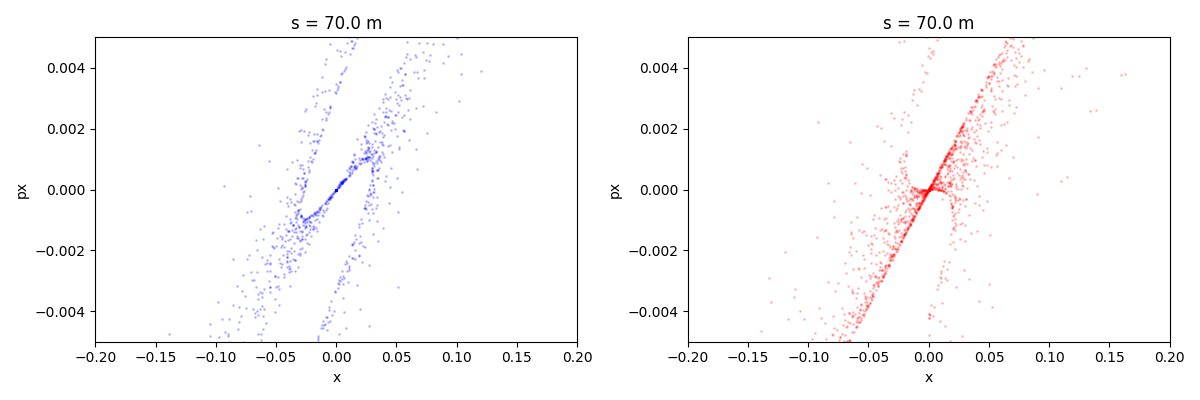

In [ ]:
fig, axt = plt.subplots(1,2, tight_layout=True, figsize=(12,4))


target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

x = line.record_last_track.x[:,s_index]
px = line.record_last_track.px[:,s_index]

axt[0].scatter(x, px, alpha=0.2, s=1, c="b")
axt[0].set_xlabel("x")
axt[0].set_ylabel("px")
axt[0].set_title(f"s = {s_array[s_index]} m")
axt[0].set_ylim(-5e-3, 5e-3)
axt[0].set_xlim(-2e-1, 2e-1)

target_s = 100
s_array = line.record_last_track.s[0]
differences = np.abs(s_array - target_s)
s_index = np.argmin(differences)

y = line.record_last_track.y[:,s_index]
py = line.record_last_track.py[:,s_index]

axt[1].scatter(y, py, alpha=0.2, s=1, c="r")
axt[1].set_xlabel("x")
axt[1].set_ylabel("px")
axt[1].set_title(f"s = {s_array[s_index]} m")
axt[1].set_ylim(-5e-3, 5e-3)
axt[1].set_xlim(-2e-1, 2e-1)

Found suitable prebuilt kernel `default_only_xtrack`.
3.8839853055749884e-05


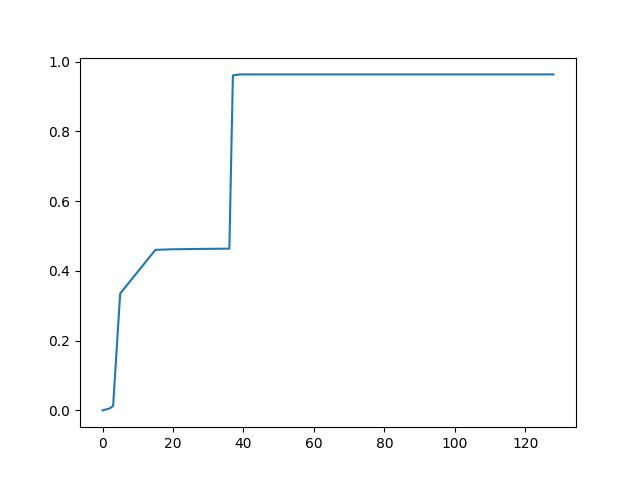

In [ ]:
tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
tw = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
tw_df = tw.to_pandas()
phase_adv = tw_df[tw_df.name == 'oct2'].mux.iloc[0] - tw_df[tw_df.name == 'oct1'].mux.iloc[0]
print(phase_adv)

fig, ax = plt.subplots()
ax.plot(tw_df.s, tw_df.mux)

# Optimize on the high correlation at the octupoles

In [ ]:
import scipy.optimize as optimize
import pybobyqa


def optimise(params):

    kQF1, kQD2, kQF3, kQD4, kq1, kq2, q1_pos = params
    print(params)

    num_part = 5000
    p, exn, eyn, betx0, bety0, alfx0, alfy0, dx0, dy0, dpx0, dpy0, ex, ey, sige = calc_initial_condition(0.5)

    # Make a transfer line
    # ====================
    k_qf_1 = 0.32730047
    k_qd_2 = -0.36102915
    k_qf_3 = 0.32789126
    k_qd_4 = -0.1991137
    l_quad = 2

    elements = [
                xt.Quadrupole(k1=k_qf_1, length=l_quad),
                xt.Drift(length=1.),
                xt.Quadrupole(k1=k_qd_2, length=l_quad),
                xt.Drift(length=29.),
                xt.Quadrupole(k1=k_qf_3, length=l_quad),
                xt.Drift(length=1.),
                xt.Quadrupole(k1=k_qd_4, length=l_quad),
                xt.Drift(length=89.),
                xt.Marker(),
            ]
    element_names = ["QF1", "drift_1", "QD2", "drift_2", "QF3", "drift_3", "QD4",
                    "drift_4", "END"]
    particle_ref = xp.Particles(energy0=p*1e9)
    line = xt.Line(elements=elements, element_names=element_names, particle_ref=particle_ref)

    # Add monitors
    # ============
    mon_air_1_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    mon_air_1_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    mon_air_2_s = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    mon_air_2_e = xt.ParticlesMonitor(start_at_turn=0, stop_at_turn=1, num_particles=num_part)
    line.insert_element(element=mon_air_1_s, name="monitor air 1 start", at_s=15)
    line.insert_element(element=mon_air_1_e, name="monitor air 1 end", at_s=20)
    line.insert_element(element=mon_air_2_s, name="monitor air 2 start", at_s=65)
    line.insert_element(element=mon_air_2_e, name="monitor air 2 end", at_s=70)

    # Add octupoles
    oct1 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
    line.insert_element(element=oct1, name="oct1", at_s=40)
    q1 = xt.Quadrupole(k1=0.5, length=0.402)
    line.insert_element(element=q1, name="q1", at_s=q1_pos)

    oct2 = xt.Multipole(order=3, knl=[0,0,0,40], length=0.5)
    line.insert_element(element=oct2, name="oct2", at_s=58)
    q2 = xt.Quadrupole(k1=0.5, length=0.402)
    line.insert_element(element=q2, name="q2", at_s=60)

    # Generate an initial distribution of particles
    # =============================================
    line.build_tracker(_context=xo.ContextCpu())

    # Change and track
    line['QF1'].k1 = kQF1
    line['QD2'].k1 = kQD2
    line['QF3'].k1 = kQF3
    line['QD4'].k1 = kQD4
    line['q1'].k1 = kq1
    line['q2'].k1 = kq2
    line['oct1'].knl = [0,0,0,0]
    line['oct2'].knl = [0,0,0,0]
    # Loop through the tracking
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")


    # First octupoles
    target_s = 48
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    px = line.record_last_track.px[:,s_index]
    pearson_coeff_oct1, p_value = pearsonr(x, px)
    betx_oct1, alfx, gammax_oct1, epsilon = twiss_parameters_from_distribution(x, px)

    obj1x = np.abs(np.std(x))

    y = line.record_last_track.y[:,s_index]
    py = line.record_last_track.py[:,s_index]
    pearson_coeff_oct1V, p_value = pearsonr(y, py)
    bety_oct1, alfy, gammay_oct1, epsilon = twiss_parameters_from_distribution(y, py)

    obj1y = np.abs(np.std(y))

    # Second octupoles
    target_s = 58
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    px = line.record_last_track.px[:,s_index]
    pearson_coeff_oct2, p_value = pearsonr(x, px)
    betx_oct2, alfx, gammax_oct2, epsilon = twiss_parameters_from_distribution(x, px)

    obj2x = np.abs(np.std(x))

    y = line.record_last_track.y[:,s_index]
    py = line.record_last_track.py[:,s_index]
    pearson_coeff_oct2V, p_value = pearsonr(y, py)
    bety_oct2, alfy, gammay_oct2, epsilon = twiss_parameters_from_distribution(y, py)

    obj2y = np.abs(np.std(y))


    correlation_objective = -(np.abs(pearson_coeff_oct1) + np.abs(pearson_coeff_oct2V))

    objective_optics_big = -(1e0*(betx_oct1 + gammax_oct1*1e3) + bety_oct2 + gammay_oct2*1e3) # you want these to be big | we change the scale of gamma
    objective_optics = (bety_oct1 + gammay_oct1*1e3 + 1e1*(betx_oct2 + gammax_oct2*1e3)) # you want these to be small

    aperture = 0.05
    objective_aperture = np.sum(np.abs(line.record_last_track.x[:,:])>aperture) + np.sum(np.abs(line.record_last_track.y[:,:])>aperture)

    # Phase advance
    tw_init = xt.TwissInit(betx=betx0, bety=bety0, alfx=alfx0, alfy=alfy0, dx=dx0, dy=dy0, dpx=dpx0, dpy=dpy0)
    twiss = line.twiss(method='6d', start="QF1", end="END", init=tw_init)
    tw_df = twiss.to_pandas()
    phase_advance_btw_oct = tw_df[tw_df.name == 'oct2'].mux.iloc[0] - tw_df[tw_df.name == 'oct1'].mux.iloc[0]

    # Beam size objective

    small_beam_size_at_oct = obj1x + obj2y
    large_beam_size_at_oct = -(obj1y + obj2x)

    objective =  small_beam_size_at_oct + large_beam_size_at_oct + objective_aperture**2
    
    print (f"OJECTIVE = {objective}")
    return objective


initial_guess = np.array([0.19, -0.17, 0.1, -0.13, 0.18776787, -0.19220195, 45])

lower = np.array([0.1, -0.25, 0.0, -0.5, -0.5, -0.5, 42])
upper = np.array([0.3, -0.1, 0.2, 0.5, 0.5, 0.5, 48])



soln = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.00001, scaling_within_bounds=True, seek_global_minimum=False, objfun_has_noise=False, maxfun=10000)
print(soln)

[ 0.19       -0.17        0.1        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 7952400.003724254
[ 0.29       -0.17        0.1        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 21874329.01120693
[ 0.19       -0.1         0.1        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 100.00105908283344
[ 0.19       -0.17        0.2        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 604914024.9825832
[ 0.19       -0.17        0.1         0.37        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3955152100.046196
[ 0.19       -0.17        0.1        -0.13        0.5        -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 59320803.995256744
[ 0.19       -0.17        0.1        -0.13        0.18776787  0.30779805
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 5645376.003724254
[ 0.19       -0.17        0.1        -0.13        0.18776787 -0.19220195
 48.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 2808976.0064652576
[ 0.1        -0.17        0.1        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 120406729.01718347
[ 0.19       -0.245       0.1        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 30935844.009902142
[ 0.19       -0.17        0.         -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 660233024.9977105
[ 0.19       -0.17        0.1        -0.5         0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 2510711449.0075235
[ 0.19       -0.17        0.1        -0.13       -0.31223213 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 38192399.99874305
[ 0.19       -0.17        0.1        -0.13        0.18776787 -0.5
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 20502784.003724255
[ 0.19       -0.17        0.1        -0.13        0.18776787 -0.19220195
 42.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 14348944.000255438
[ 2.26953077e-01 -1.00000000e-01  1.02182289e-01 -1.14501037e-01
  2.47810402e-02  1.37637698e-01  4.66985784e+01]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 84100.00232350534
[ 0.22633005 -0.1         0.10222856 -0.11504815  0.08198053 -0.23981075
 44.24825233]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 509796.00183626026
[ 0.19       -0.1145      0.1        -0.13        0.18776787 -0.19220195
 45.        ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 28224.000757543014
[ 0.20203339 -0.10504557  0.10061849 -0.11582995  0.11367791 -0.16450687
 45.39830194]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.00018206928874322115
[ 0.19514436 -0.10337345  0.10109227 -0.10984693  0.07998911 -0.16488117
 45.37684955]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 195.9981634750154
[ 0.19804013 -0.10643851  0.10224811 -0.1130811   0.12035539 -0.13406982
 45.21141735]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 15.998588195656058
[ 0.20193745 -0.10506241  0.09081176 -0.11463707  0.11140636 -0.15625478
 45.37095024]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 0.00011496889202682612
[ 0.19608002 -0.10625594  0.09634204 -0.11301275  0.11239817 -0.18209776
 45.23152674]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 15.999021716910795
[ 0.20156401 -0.1083703   0.10904648 -0.10634998  0.11703528 -0.17489868
 45.3726322 ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 6399.998499487873
[ 0.20114006 -0.10335047  0.09715719 -0.09876372  0.15136878 -0.16521052
 45.50901414]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 16.00014187021284
[ 0.20257149 -0.10733924  0.10035594 -0.06842944  0.11141328 -0.16481192
 45.38463642]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 280900.00052747043
[ 0.20904289 -0.10601897  0.09877591 -0.09610855  0.08640476 -0.16302235
 45.37959416]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 64.00007541080909
[ 0.2015477  -0.10894601  0.10111623 -0.15820092  0.11460433 -0.16541053
 45.37523244]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 9604.004707591046
[ 0.2003109  -0.11075307  0.09917776 -0.11389886  0.10637428 -0.15561791
 45.56694835]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0007342649517465059
[ 0.2051487  -0.1150802   0.09828514 -0.11946711  0.12397201 -0.16590434
 45.4179961 ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 0.00040484308746687424
[ 0.1989005  -0.11064846  0.10012816 -0.11469761  0.08761169 -0.16202355
 45.49141123]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 63.99914174320779
[ 0.20143316 -0.11160898  0.09911092 -0.11246596  0.09865859 -0.15338396
 45.59725703]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0008352752961795428
[ 0.20117935 -0.11069745  0.0985896  -0.1076698   0.09018486 -0.1507708
 45.61553615]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9986813447104503
[ 0.20133797 -0.11176434  0.09871674 -0.11141662  0.09884532 -0.15704372
 45.61105239]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0009582593806266113
[ 0.20145304 -0.11186564  0.09940463 -0.11416522  0.09766869 -0.15820569
 45.61973419]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0006156823814627089
[ 0.20188072 -0.111741    0.09849926 -0.11048638  0.10187265 -0.15572716
 45.62401233]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0009934351870296667
[ 0.20203655 -0.11226159  0.09826346 -0.11225401  0.10040346 -0.15363461
 45.63084314]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.000742855971429104
[ 0.20149945 -0.11204111  0.09905779 -0.10764967  0.10233637 -0.15505332
 45.62953681]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9987237568282343
[ 0.2023849  -0.11191022  0.09884673 -0.10888689  0.09973925 -0.15611054
 45.60802791]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9988683037927952
[ 0.20192952 -0.11141007  0.09776909 -0.11060958  0.10229221 -0.15544998
 45.60874284]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0009063612096011527
[ 0.20186415 -0.11158592  0.09793541 -0.10741062  0.10202752 -0.15319086
 45.62255588]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0011758997099476144
[ 0.2018127  -0.1117227   0.09780584 -0.1039817   0.10019815 -0.15381969
 45.63971956]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9989095287754446
[ 0.20208602 -0.11122192  0.09767508 -0.10701819  0.10214597 -0.15405354
 45.59910665]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0011312683013789614
[ 0.2019609  -0.11198863  0.09783865 -0.10748767  0.1050107  -0.15368706
 45.60540336]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0011563252151921416
[ 0.20195781 -0.11177104  0.09770819 -0.10928382  0.10628729 -0.15336784
 45.61937507]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0010490685792517581
[ 0.20173994 -0.11168504  0.0978186  -0.10746147  0.10003756 -0.15217563
 45.62438937]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012022318146549331
[ 0.20178992 -0.11170993  0.09777753 -0.10719859  0.10027116 -0.15116917
 45.62764108]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0011969078574774988
[ 0.2017775  -0.111753    0.09791274 -0.10720311  0.09993869 -0.15221297
 45.63045646]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012066363058088573
[ 0.20176443 -0.11173031  0.09798924 -0.10724922  0.09988022 -0.15196055
 45.62994381]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012102898643122316
[ 0.20170601 -0.11172855  0.09796774 -0.10688992  0.10001209 -0.15194336
 45.63041678]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9987849426747157
[ 0.20170121 -0.11174715  0.09801541 -0.10746087  0.0997619  -0.15215716
 45.62903605]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.001217935713469767
[ 0.20175067 -0.11177753  0.0980453  -0.10757489  0.09990305 -0.15212438
 45.62722118]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012118724761922166
[ 0.20170614 -0.11175541  0.09801566 -0.10723381  0.09932925 -0.15210176
 45.62863123]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.998776750892225
[ 0.20171229 -0.1117195   0.09798262 -0.10729719  0.09942277 -0.15204627
 45.63010861]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012185816046441323
[ 0.20170042 -0.11176268  0.09800033 -0.10742039  0.09940343 -0.15202395
 45.63235119]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.001220471049997732
[ 0.20172431 -0.11178017  0.09806157 -0.10713635  0.09928395 -0.15214738
 45.63316018]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9987762128997657
[ 0.2016874  -0.11178852  0.09800228 -0.10712563  0.09941516 -0.15167364
 45.63282547]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.9987745610484517
[ 0.20171585 -0.11179937  0.09802741 -0.10764635  0.09915047 -0.15189349
 45.63124788]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012183285437756704
[ 0.20173593 -0.11176444  0.09803321 -0.10773659  0.09952354 -0.15228011
 45.63298845]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012099715610339966
[ 0.20172646 -0.11176626  0.09797024 -0.10702876  0.09942201 -0.15186495
 45.63340477]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.998781091167639
[ 0.20168655 -0.1117763   0.09804177 -0.10746948  0.0994179  -0.15207397
 45.63257606]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012233446523418345
[ 0.20168187 -0.111781    0.09803883 -0.10750533  0.0993798  -0.1520723
 45.63320939]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012234552054502606
[ 0.2017017  -0.11178881  0.09804354 -0.10751752  0.09937776 -0.15211992
 45.63314737]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012214228716299455
[ 0.20168297 -0.11177304  0.09804237 -0.10749593  0.09935527 -0.15205702
 45.63339121]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.001223484492099565
[ 0.20168108 -0.11177545  0.09804217 -0.1074737   0.09929625 -0.15206958
 45.6332549 ]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012245836399417502
[ 0.20167798 -0.11177574  0.09804522 -0.10750687  0.09926636 -0.15211578
 45.63337429]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012246583077587308
[ 0.20168073 -0.11177774  0.09805088 -0.1075398   0.09930965 -0.15213966
 45.63347883]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012237136395912176
[ 0.20167777 -0.11178049  0.09804952 -0.10750013  0.09923742 -0.15208802
 45.63363434]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.001225306493220876
[ 0.20167224 -0.11177913  0.09804158 -0.10752484  0.09922177 -0.15207389
 45.63386805]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012251558217698474
[ 0.20166964 -0.11178202  0.09805558 -0.10753262  0.09922489 -0.15208355
 45.63343623]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012260531490223196
[ 0.2016697  -0.11178014  0.09805436 -0.10756665  0.09916509 -0.15208932
 45.63339934]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012255992212835802
[ 0.20166584 -0.11177968  0.09805572 -0.10751969  0.09921654 -0.15208943
 45.63355232]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012267028809160442
[ 0.20166536 -0.11178038  0.0980554  -0.10750947  0.09920856 -0.1520791
 45.63353623]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.998772978172462
[ 0.20166625 -0.11177907  0.0980556  -0.10753267  0.09922129 -0.15209404
 45.63360576]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012263332530209618
[ 0.20166541 -0.11177891  0.09805611 -0.10751464  0.0992204  -0.15209092
 45.63358109]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.998773190937284
[ 0.20166534 -0.11178061  0.09805518 -0.10752048  0.09921535 -0.15209617
 45.63355246]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012267652755685269
[ 0.20166643 -0.11178083  0.09805595 -0.10751849  0.09921047 -0.15209784
 45.63358111]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012267444491683563
[ 0.20166545 -0.11178001  0.09805564 -0.10752438  0.09921081 -0.15209948
 45.63351877]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012267088734421313
[ 0.201664   -0.1117803   0.09805552 -0.10752247  0.09921101 -0.15209348
 45.63357775]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012269093940241497
[ 0.2016643  -0.11178096  0.0980557  -0.10752989  0.09920935 -0.15208905
 45.63357793]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012267707690508168
[ 0.20166322 -0.1117806   0.09805691 -0.10752037  0.09920933 -0.15209107
 45.63355124]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = 3.998772874278396
[ 0.20166456 -0.11177991  0.09805399 -0.10752493  0.0992067  -0.15209199
 45.63358269]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.001226744440113734
[ 0.20166339 -0.1117808   0.09805626 -0.10752166  0.09920568 -0.15209166
 45.63361247]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012270740799572386
[ 0.20166281 -0.11178121  0.09805585 -0.10752422  0.09920785 -0.15209557
 45.63365625]
4.186718824869724
gamma = 4.463
beta = 0.975
p = 4.187 GeV/c
Found suitable prebuilt kernel `default_only_xtrack`.
Compiling ContextCpu kernels...


ld: warning: -pie being ignored. It is only used when linking a main executable
ld: warning: -pie being ignored. It is only used when linking a main executable


Done compiling ContextCpu kernels.
Found suitable prebuilt kernel `default_only_xtrack`.
OJECTIVE = -0.0012270685974039577
****** Py-BOBYQA Results ******
Solution xmin = [ 0.20166339 -0.1117808   0.09805626 -0.10752166  0.09920568 -0.15209166
 45.63361247]
Objective value f(xmin) = -0.00122707408
Needed 84 objective evaluations (at 84 points)
Approximate gradient = [-129577.94563878  256711.75485575  865979.6496656   201440.28367947
  -72441.77165045  131430.64788812  -42504.37540392]
Approximate Hessian = [[-8.34573477e+10 -6.69291418e+10 -1.00872773e+11 -1.33799846e+10
   9.39632142e+09 -3.51430101e+10  1.04304784e+10]
 [-6.69291418e+10  1.19978441e+12 -5.85466784e+09  6.30395377e+10
   3.94848896e+10 -2.82581397e+10  2.24263201e+10]
 [-1.00872773e+11 -5.85466784e+09  6.48159392e+11  4.39852920e+10
   3.88086352e+10  2.36782082e+10 -3.60639836e+09]
 [-1.33799846e+10  6.30395377e+10  4.39852920e+10  1.72752282e+10
  -3.05998069e+09 -4.10590271e+09 -6.43475854e+08]
 [ 9.39632142e+09  

# Optimise on the k_s statistic

In [ ]:
import scipy.optimize as optimize
import pybobyqa


def optimise(params):

    oct1, oct2 = params
    print(params)


    # Change and track
    line['QF1'].k1 = soln.x[0]
    line['QD2'].k1 = soln.x[1]
    line['QF3'].k1 = soln.x[2]
    line['QD4'].k1 = soln.x[3]
    line['q1'].k1 = soln.x[4]
    line['q2'].k1 = soln.x[5]
    line['oct1'].knl = [0,0,0,oct1]
    line['oct2'].knl = [0,0,0,oct2]
    # Loop through the tracking
    part = line.build_particles(x_norm=x_norm, px_norm=px_norm, y_norm=y_norm, py_norm=py_norm,
                                W_matrix=tw.W_matrix[0], particle_on_co=line.particle_ref,
                                nemitt_x=nemitt_x,nemitt_y=nemitt_y)
    part._init_random_number_generator()
    line.track(part, turn_by_turn_monitor="ONE_TURN_EBE")

    #DUT
    target_s = 100
    s_array = line.record_last_track.s[0]
    differences = np.abs(s_array - target_s)
    s_index = np.argmin(differences)
    x = line.record_last_track.x[:,s_index]
    y = line.record_last_track.y[:,s_index]

    data = x
    data_min, data_max = np.min(data), np.max(data)
    uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
    statisticH, p_valueH = kstest(data, uniform_dist.cdf)

    data = y
    data_min, data_max = np.min(data), np.max(data)
    uniform_dist = uniform(loc=data_min, scale=data_max-data_min)
    statisticV, p_valueV = kstest(data, uniform_dist.cdf)

    objective = np.abs(statisticH) + np.abs(statisticV) + -np.abs(p_valueH) + -np.abs(p_valueV)
    
    print (f"OJECTIVE = {objective}")
    return objective



initial_guess = np.array([0.0, 0.0])

lower = np.array([-600, -600])
upper = np.array([600, 600])


solnOct = pybobyqa.solve(optimise, initial_guess, bounds=(lower,upper), rhobeg = 0.5, rhoend=0.001, scaling_within_bounds=True, seek_global_minimum=False, objfun_has_noise=False, maxfun=1000)
print(solnOct)

[0. 0.]
OJECTIVE = 0.5162122594704996
[600.   0.]
OJECTIVE = 0.7456422901206432
[  0. 600.]
OJECTIVE = 0.9136124600948128
[-600.    0.]
OJECTIVE = 0.829196486362789
[   0. -600.]
OJECTIVE = 0.9281794499079468
[46.21238938  5.39939834]
OJECTIVE = 0.6450702425545889
[-29.9996606    0.14270179]
OJECTIVE = 0.6230549501608712
[-0.64491523 14.98612973]
OJECTIVE = 0.7128103019323222
[  1.91095552 -14.87777702]
OJECTIVE = 0.505572454859663
[ 5.64661825 -7.83735017]
OJECTIVE = 0.43920727033531404
[11.76966985 -5.30951344]
OJECTIVE = 0.46204891828253014
[ 1.65696199 -9.28048665]
OJECTIVE = 0.44038641672498396
[ 5.21773175 -9.91486223]
OJECTIVE = 0.4342004113363422
[  4.90381494 -12.01282702]
OJECTIVE = 0.4811585546863286
[ 6.33257806 -9.47088284]
OJECTIVE = 0.43133569181751524
[ 5.43738867 -9.08078896]
OJECTIVE = 0.4335359649253241
****** Py-BOBYQA Results ******
Solution xmin = [ 6.33257806 -9.47088284]
Objective value f(xmin) = 0.4313356918
Needed 16 objective evaluations (at 16 points)
Approx